2025-01-08 23:35:47,728 - INFO - Iniciando proceso mejorado con EfficientNet-B0, Early Stopping, estratificación y regularización extra...
2025-01-08 23:35:47,729 - INFO - Inicializando StanfordDogsDataset...
2025-01-08 23:35:47,729 - INFO - Preparando Stanford Dogs dataset...
2025-01-08 23:35:50,296 - INFO - StanfordDogsDataset preparado con 20580 muestras.
2025-01-08 23:35:50,296 - INFO - Inicializando NineBreedsDataset...
2025-01-08 23:35:50,296 - INFO - df_breed con 21624 muestras.

2025-01-08 23:35:50,379 - INFO - df_emotion con 15921 muestras.

2025-01-08 23:35:50,395 - INFO - Usando dispositivo: cuda
2025-01-08 23:35:50,396 - INFO - Dividiendo el dataset en train/val/test con estratificación...
2025-01-08 23:35:50,429 - INFO - Train: 15136, Val: 4325, Test: 2163
2025-01-08 23:35:50,430 - INFO - Creando BreedDataset...
2025-01-08 23:35:50,433 - INFO - BreedDataset con 15136 muestras. 125 clases de raza.
2025-01-08 23:35:50,433 - INFO - Creando BreedDataset...
2025-01-08 23:35:50,

Creando transformaciones de data augmentation...
Creando transformaciones de data augmentation...


2025-01-08 23:35:50,749 - INFO - Creando BreedClassifierResNet con ResNet34.
2025-01-08 23:35:51,131 - INFO - 
===== ENTRENANDO MODELO DE RAZAS (EfficientNet-B0) =====
2025-01-08 23:35:51,131 - INFO - 
Iniciando entrenamiento...
2025-01-08 23:35:51,230 - INFO - === Época 1/50 ===
2025-01-09 00:00:42,484 - INFO - Train Loss: 3.4051 | Val Loss: 2.7692 | Train Acc: 25.81% | Val Acc: 39.05%
2025-01-09 00:00:42,485 - INFO - Learning Rate actual: 0.000700
2025-01-09 00:00:42,511 - INFO - === Época 2/50 ===
2025-01-09 00:28:43,853 - INFO - Train Loss: 2.5253 | Val Loss: 2.3448 | Train Acc: 46.94% | Val Acc: 50.68%
2025-01-09 00:28:43,854 - INFO - Learning Rate actual: 0.000700
2025-01-09 00:28:43,880 - INFO - === Época 3/50 ===
2025-01-09 00:43:32,523 - INFO - Train Loss: 2.2149 | Val Loss: 2.2308 | Train Acc: 57.80% | Val Acc: 55.17%
2025-01-09 00:43:32,523 - INFO - Learning Rate actual: 0.000700
2025-01-09 00:43:32,561 - INFO - === Época 4/50 ===
2025-01-09 01:00:45,234 - INFO - Train Loss:

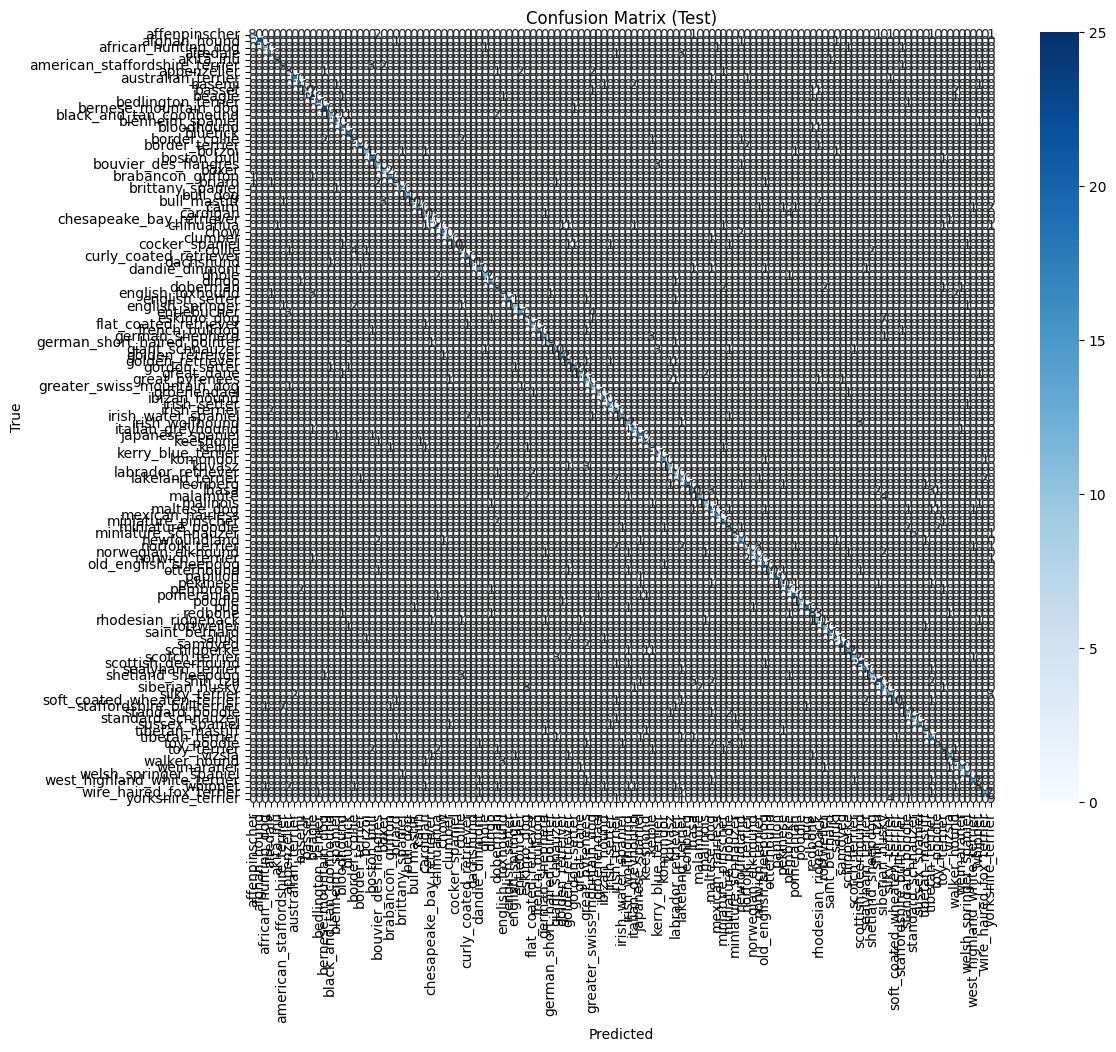

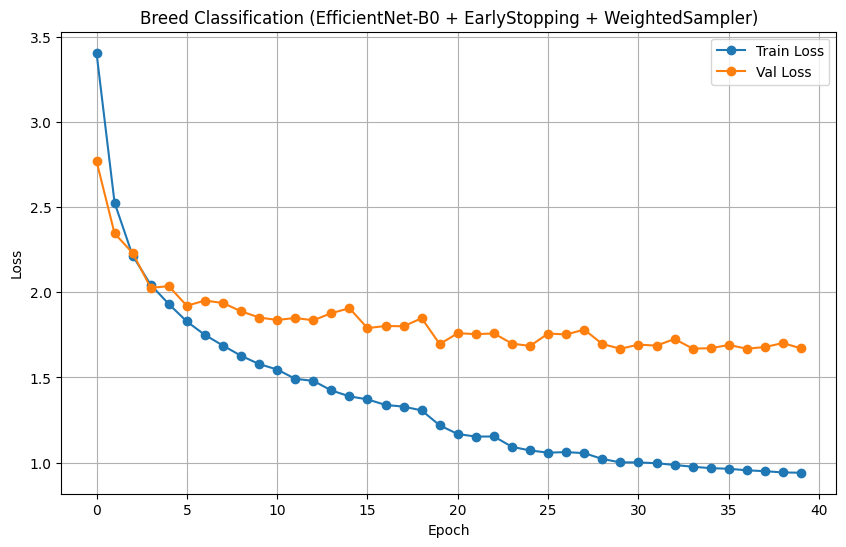

2025-01-09 09:44:03,167 - INFO - Modelo de razas guardado en: models\efficientnetb0_breed_improved.pth

2025-01-09 09:44:03,167 - INFO - Dividiendo el dataset en train/val/test con estratificación...
2025-01-09 09:44:03,190 - INFO - Train: 11144, Val: 3184, Test: 1593
2025-01-09 09:44:03,191 - INFO - Creando EmotionDataset...
2025-01-09 09:44:03,195 - INFO - EmotionDataset con 11144 muestras, 4 clases de emoción.
2025-01-09 09:44:03,195 - INFO - Creando EmotionDataset...
2025-01-09 09:44:03,197 - INFO - EmotionDataset con 3184 muestras, 4 clases de emoción.
2025-01-09 09:44:03,197 - INFO - Creando EmotionDataset...
2025-01-09 09:44:03,199 - INFO - EmotionDataset con 1593 muestras, 4 clases de emoción.


Creando transformaciones de data augmentation...
Creando transformaciones de data augmentation...


2025-01-09 09:44:03,446 - INFO - Creando EmotionClassifierResNet con ResNet34.
2025-01-09 09:44:03,809 - INFO - 
===== ENTRENANDO MODELO DE EMOCIONES (EfficientNet-B0) =====
2025-01-09 09:44:03,809 - INFO - 
Iniciando entrenamiento...
2025-01-09 09:44:03,924 - INFO - === Época 1/30 ===


In [ ]:
import os
import glob
import copy
import logging
import pandas as pd
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------------------------
#                              CONFIGURACIONES
# -----------------------------------------------------------------------------
SEED = 20
torch.manual_seed(SEED)
np.random.seed(SEED)

# Configurar el logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
)

# -----------------------------------------------------------------------------
#                               DATASETS
# -----------------------------------------------------------------------------

class StanfordDogsDataset(Dataset):
    """
    Dataset para Stanford Dogs con recorte de las imágenes al bounding box.
    Cada imagen debe contar con su archivo XML. Si el XML contiene múltiples
    objetos, se toma el primero y se advierte si hay más.
    """
    def __init__(self, images_dir, annotations_dir, transform=None):
        logging.info("Inicializando StanfordDogsDataset...")
        self.images_dir = os.path.normpath(images_dir)
        self.annotations_dir = os.path.normpath(annotations_dir)
        self.transform = transform

        self.data = []
        self.labels = []
        self._prepare_dataset()

    def _prepare_dataset(self):
        logging.info("Preparando Stanford Dogs dataset...")

        # Admite extensiones variadas
        image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            image_paths.extend(glob.glob(os.path.join(self.images_dir, '*', ext)))

        for img_path in image_paths:
            img_path = os.path.normpath(img_path)
            breed_folder = os.path.basename(os.path.dirname(img_path))
            image_name = os.path.splitext(os.path.basename(img_path))[0]

            # Extraer la parte de raza limpiando el prefijo numérico (si existe)
            if '-' in breed_folder:
                clean_breed = '-'.join(breed_folder.split('-')[1:])
            else:
                clean_breed = breed_folder

            # Construir la ruta de anotación (XML)
            ann_path = os.path.join(self.annotations_dir, breed_folder, f"{image_name}.xml")
            ann_path = os.path.normpath(ann_path)

            if not os.path.exists(ann_path):
                logging.warning(f"Anotación faltante para la imagen: {img_path}")
                continue

            self.data.append((img_path, ann_path, clean_breed))
            self.labels.append(clean_breed)

        logging.info(f"StanfordDogsDataset preparado con {len(self.data)} muestras.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, ann_path, breed_label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        # Recortar según bounding box principal
        image = self._crop_to_bounding_box(image, ann_path)

        if self.transform:
            image = self.transform(image)

        return image, breed_label

    def _crop_to_bounding_box(self, image, ann_path):
        try:
            tree = ET.parse(ann_path)
            root = tree.getroot()
            objects = root.findall('object')
            if len(objects) == 0:
                logging.warning(f"No se encontró <object> en: {ann_path}")
                return image

            if len(objects) > 1:
                logging.warning(
                    f"Se encontraron {len(objects)} objetos en {ann_path}. "
                    f"Usando el primero únicamente."
                )

            obj = objects[0]
            bndbox = obj.find('bndbox')
            if bndbox is not None:
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # Asegurar que estén dentro de la imagen
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                width, height = image.size
                xmax = min(xmax, width)
                ymax = min(ymax, height)

                if (xmax > xmin) and (ymax > ymin):
                    image = image.crop((xmin, ymin, xmax, ymax))
        except Exception as e:
            logging.error(f"Error al parsear {ann_path}: {e}")
        return image


class NineBreedsDataset(Dataset):
    """
    Dataset para 9Breeds usando internamente ImageFolder.
    """
    def __init__(self, folder_path, transform=None):
        logging.info("Inicializando NineBreedsDataset...")
        self.folder_path = os.path.normpath(folder_path)
        self.transform = transform

        self.imagefolder = datasets.ImageFolder(root=self.folder_path)
        self.idx_to_class = {v: k for k, v in self.imagefolder.class_to_idx.items()}
        self.samples = self.imagefolder.samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        class_name = self.idx_to_class[class_idx]
        return image, class_name


class BreedDataset(Dataset):
    """
    Dataset unificado para razas. Recibe un DataFrame con columnas ['image', 'Breed'].
    """
    def __init__(self, dataframe, transform=None):
        logging.info("Creando BreedDataset...")
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

        self.breed_set = sorted(set(self.dataframe['Breed'].dropna()))
        self.breed_to_idx = {b: i for i, b in enumerate(self.breed_set)}
        self.idx_to_breed = {i: b for b, i in self.breed_to_idx.items()}

        logging.info(f"BreedDataset con {len(self.dataframe)} muestras. "
                     f"{len(self.breed_set)} clases de raza.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        breed_str = row['Breed']
        if breed_str not in self.breed_to_idx:
            raise ValueError(f"Raza desconocida: {breed_str} en idx {idx}")

        breed_label = self.breed_to_idx[breed_str]
        return image, breed_label


class EmotionDataset(Dataset):
    """
    Dataset para clasificación de emociones. Recibe un DataFrame con columnas ['image', 'Emotion'].
    """
    def __init__(self, dataframe, transform=None):
        logging.info("Creando EmotionDataset...")
        df_filtered = dataframe[dataframe['Emotion'].notna()].reset_index(drop=True)
        self.dataframe = df_filtered
        self.transform = transform

        self.emotion_set = sorted(set(self.dataframe['Emotion'].dropna()))
        self.emotion_to_idx = {emo: i for i, emo in enumerate(self.emotion_set)}
        self.idx_to_emotion = {i: emo for emo, i in self.emotion_to_idx.items()}

        logging.info(f"EmotionDataset con {len(self.dataframe)} muestras, "
                     f"{len(self.emotion_set)} clases de emoción.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        emo_str = row['Emotion']
        if emo_str not in self.emotion_to_idx:
            raise ValueError(f"Emoción desconocida: {emo_str} en idx {idx}")

        emotion_label = self.emotion_to_idx[emo_str]
        return image, emotion_label

# -----------------------------------------------------------------------------
#                       TRANSFORMACIONES (Data Augmentation)
# ----------------------------------------------------------------------------
def get_transforms():
    """
    Data Augmentation: RandomResizedCrop, flips, rotations, color jitter, etc.
    """
    print("Creando transformaciones de data augmentation...")
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


# -----------------------------------------------------------------------------
#                   DIVISIÓN EN TRAIN/VAL/TEST (con Estratificación)
# -----------------------------------------------------------------------------

def split_dataset_stratified(df, label_column, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=SEED):
    """
    Divide el dataset en tres subconjuntos usando estratificación (para clasificación).
    Retorna (train_df, val_df, test_df).
    """
    logging.info("Dividiendo el dataset en train/val/test con estratificación...")

    # Se asume que train_ratio + val_ratio + test_ratio = 1.0
    sss_train_val = StratifiedShuffleSplit(n_splits=1, 
                                           train_size=train_ratio, 
                                           random_state=seed)
    sss_val_test = StratifiedShuffleSplit(n_splits=1, 
                                          train_size=val_ratio/(val_ratio+test_ratio),
                                          random_state=seed)

    df = df.reset_index(drop=True)

    for train_index, temp_index in sss_train_val.split(df, df[label_column]):
        train_df = df.loc[train_index]
        temp_df = df.loc[temp_index]

    temp_df = temp_df.reset_index(drop=True)
    for val_index, test_index in sss_val_test.split(temp_df, temp_df[label_column]):
        val_df = temp_df.loc[val_index]
        test_df = temp_df.loc[test_index]

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    logging.info(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    return train_df, val_df, test_df

# -----------------------------------------------------------------------------
#                            MODELOS (ResNet34)
# -----------------------------------------------------------------------------

class BreedClassifierResNet(nn.Module):
    """
    Modelo ResNet34 para clasificación de razas.
    Opción de congelar/descongelar capas iniciales.
    """
    def __init__(self, num_breeds, dropout_p=0.5, freeze_backbone=False):
        super().__init__()
        logging.info("Creando BreedClassifierResNet con ResNet34.")
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        if freeze_backbone:
            for param in self.resnet.layer1.parameters():
                param.requires_grad = False
            for param in self.resnet.layer2.parameters():
                param.requires_grad = False

        # Reemplazar la FC final
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_breeds)
        ) 

    def forward(self, x):
        return self.resnet(x)


class EmotionClassifierResNet(nn.Module):
    """
    Modelo ResNet34 para clasificación de emociones.
    Opción de congelar/descongelar capas iniciales.
    """
    def __init__(self, num_emotions, dropout_p=0.5, freeze_backbone=False):
        super().__init__()
        logging.info("Creando EmotionClassifierResNet con ResNet34.")
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Freeze all layers except the last block
        if freeze_backbone:
            for param in self.efficientnet.features[:-1].parameters():
                param.requires_grad = False
                
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_emotions)
        )

    def forward(self, x):
        return self.resnet(x)

# -----------------------------------------------------------------------------
#                            MODELOS (EfficientNet-B0)
# -----------------------------------------------------------------------------

class BreedClassifierEfficientNet(nn.Module):
    """
    Modelo EfficientNet-B0 para clasificación de razas.
    Opción de congelar/descongelar capas iniciales.
    """
    def __init__(self, num_breeds, dropout_p=0.5, freeze_backbone=False):
        super().__init__()
        logging.info("Creando BreedClassifierEfficientNet con EfficientNet-B0.")
        # Cargar EfficientNet-B0 preentrenado
        weights = EfficientNet_B0_Weights.DEFAULT
        self.efficientnet = efficientnet_b0(weights=weights)
        
        if freeze_backbone:
            for param in self.efficientnet.features.parameters():
                param.requires_grad = False

        # Reemplazar la capa fully connected (classifier) final
        # EfficientNet-B0 classifier por defecto: Sequential(Dropout(p=0.2), Linear(...,1000))
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_breeds),
        )

    def forward(self, x):
        return self.efficientnet(x)


class EmotionClassifierEfficientNet(nn.Module):
    """
    Modelo EfficientNet-B0 para clasificación de emociones.
    Opción de congelar/descongelar capas iniciales.
    """
    def __init__(self, num_emotions, dropout_p=0.5, freeze_backbone=False):
        super().__init__()
        logging.info("Creando EmotionClassifierEfficientNet con EfficientNet-B0.")
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        self.efficientnet = efficientnet_b0(weights=weights)
        
        if freeze_backbone:
            for param in self.efficientnet.features.parameters():
                param.requires_grad = False

        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, num_emotions)
        )

    def forward(self, x):
        return self.efficientnet(x)

# -----------------------------------------------------------------------------
#             FUNCIÓN PARA CONTAR ACIERTOS Y OBTENER EXACTITUD
# -----------------------------------------------------------------------------

def count_correct_predictions(outputs, labels):
    """
    Retorna la cantidad (no el porcentaje) de predicciones correctas.
    """
    _, predicted = torch.max(outputs, dim=1)
    return (predicted == labels).sum().item()

# -----------------------------------------------------------------------------
#        ENTRENAMIENTO (Una sola fase, con EarlyStopping y label smoothing)
# -----------------------------------------------------------------------------

def train_classification_model(
    model, 
    train_loader, 
    val_loader, 
    class_names,
    device='cuda', 
    epochs=30,               
    lr = 1e-4, 
    weight_decay=1e-5,
    early_stopping_patience=5,
    scheduler_factor=0.6
):
    logging.info("\nIniciando entrenamiento...")
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=3)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs + 1):
        logging.info(f"=== Época {epoch}/{epochs} ===")

        # -- Fase de entrenamiento --
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_samples_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_correct += count_correct_predictions(outputs, labels)
            total_samples_train += images.size(0)

        avg_train_loss = running_loss / total_samples_train
        train_accuracy = 100.0 * running_correct / total_samples_train

        # -- Fase de validación --
        model.eval()
        val_running_loss = 0.0
        running_correct_val = 0
        total_samples_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)

                val_running_loss += val_loss.item() * images.size(0)
                running_correct_val += count_correct_predictions(outputs, labels)
                total_samples_val += images.size(0)

        avg_val_loss = val_running_loss / total_samples_val
        val_accuracy = 100.0 * running_correct_val / total_samples_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        logging.info(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
                     f"| Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

        # Ajustar LR con ReduceLROnPlateau
        scheduler.step(avg_val_loss)
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        logging.info(f"Learning Rate actual: {current_lr:.6f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            logging.info(f"Epochs sin mejora: {epochs_no_improve}/{early_stopping_patience}")
            if epochs_no_improve >= early_stopping_patience:
                logging.info(f"[EARLY STOPPING] No mejora en val_loss tras {early_stopping_patience} épocas.")
                break

    # Restaurar los mejores pesos
    model.load_state_dict(best_model_wts)
    logging.info("Entrenamiento finalizado. Se restauró el mejor modelo.\n")

    return train_losses, val_losses

# -----------------------------------------------------------------------------
#             FUNCIÓN PARA EVALUAR EL MODELO
# -----------------------------------------------------------------------------

def evaluate_classification_model(model, test_loader, class_names, device='cuda'):
    """
    Evalúa el modelo con un conjunto de test, mostrando el classification report,
    la matriz de confusión y calculando la exactitud global.
    """
    logging.info("Evaluando en conjunto de TEST...\n")

    model.to(device)
    model.eval()

    preds, true_labels = [], []
    running_correct = 0
    total_samples_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)

            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            running_correct += (predicted == labels).sum().item()
            total_samples_test += labels.size(0)

    test_accuracy = 100.0 * running_correct / total_samples_test
    logging.info(f"Exactitud global en TEST: {test_accuracy:.2f}%\n")

    logging.info("Classification Report (Test):")
    report = classification_report(
        true_labels, 
        preds, 
        target_names=class_names, 
        zero_division=0
    )
    logging.info("\n" + report)

    cm = confusion_matrix(true_labels, preds, labels=range(len(class_names)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test)')

    # Para entornos interactivos:
    plt.show()

    # O para entornos headless, se puede usar:
    # plt.savefig('confusion_matrix_test.png')
    # plt.close()

def plot_losses(train_losses, val_losses, title):
    """
    Grafica las pérdidas (entrenamiento y validación) a lo largo de las épocas.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # O, en modo headless:
    # plt.savefig(f"{title}.png")
    # plt.close()

# -----------------------------------------------------------------------------
#                                MAIN
# -----------------------------------------------------------------------------

def main():
    logging.info("Iniciando proceso mejorado con EfficientNet-B0, Early Stopping, estratificación y regularización extra...")

    # Directorios (ajustar según la estructura local)
    stanford_images_path = './datasets/stanford_breeds/Images'
    stanford_annotations_path = './datasets/stanford_breeds/Annotation'
    nine_breeds_path = './datasets/9Breeds'
    emotion_path = './datasets/dogs_emotions'

    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

    # 1) Cargar datasets de raza (Stanford Dogs + 9Breeds) pero sin transformaciones.
    #    Se usa cada clase para extraer rutas e información de etiqueta.
    stanford_dataset = StanfordDogsDataset(
        images_dir=stanford_images_path,
        annotations_dir=stanford_annotations_path,
        transform=None
    )

    nine_breeds_dataset = NineBreedsDataset(
        folder_path=nine_breeds_path,
        transform=None
    )

    # Unificar en df_breed (rutas + etiqueta de raza)
    breed_images_stanford = [img_path for (img_path, _, _) in stanford_dataset.data]
    breed_labels_stanford = stanford_dataset.labels

    breed_images_9b = [path for (path, _) in nine_breeds_dataset.samples]
    breed_labels_9b = [nine_breeds_dataset.idx_to_class[idx] for (_, idx) in nine_breeds_dataset.samples]

    breed_images = breed_images_stanford + breed_images_9b
    breed_labels = breed_labels_stanford + breed_labels_9b

    # Limpieza básica de la etiqueta (guiones, espacios, etc.)
    breed_labels_clean = [b.lower().replace('-', '_').replace(' ', '_') for b in breed_labels]

    df_breed = pd.DataFrame({'image': breed_images, 'Breed': breed_labels_clean})
    logging.info(f"df_breed con {len(df_breed)} muestras.\n")

    # 2) Dataset de emociones (similar procedimiento)
    emotion_dataset = datasets.ImageFolder(root=emotion_path)
    emotion_images = [os.path.normpath(img_path) for (img_path, _) in emotion_dataset.samples]
    emotion_labels_raw = [emotion_dataset.classes[idx] for (_, idx) in emotion_dataset.samples]
    emotion_labels_clean = [e.lower().replace(' ', '_') for e in emotion_labels_raw]

    df_emotion = pd.DataFrame({'image': emotion_images, 'Emotion': emotion_labels_clean})
    logging.info(f"df_emotion con {len(df_emotion)} muestras.\n")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logging.info(f"Usando dispositivo: {device}")

    # -------------------------------------------------------------------------
    # Entrenamiento Modelo de RAZAS (EfficientNet-B0) con estratificación y WeightedRandomSampler
    # -------------------------------------------------------------------------
    if len(df_breed) < 2:
        logging.warning("No hay suficientes datos de razas para entrenar.")
    else:
        # Se realiza la división estratificada por la columna 'Breed'.
        train_df_breed, val_df_breed, test_df_breed = split_dataset_stratified(
            df_breed, 
            label_column='Breed', 
            train_ratio=0.7, 
            val_ratio=0.2, 
            test_ratio=0.1, 
            seed=SEED
        )

        # Transformaciones para data augmentation
        transforms_breed = get_transforms()

        train_dataset_breed = BreedDataset(train_df_breed, transform=transforms_breed)
        val_dataset_breed = BreedDataset(val_df_breed, transform=transforms_breed)
        test_dataset_breed = BreedDataset(test_df_breed, transform=get_transforms())

        # Uso de WeightedRandomSampler para manejar desbalanceo de clases
        label_counts = train_df_breed['Breed'].value_counts()
        class_weights = {}
        for breed_ in label_counts.index:
            class_weights[breed_] = 1.0 / label_counts[breed_]  # inverso de la frecuencia

        sample_weights = []
        for idx in range(len(train_dataset_breed)):
            breed_str = train_df_breed.iloc[idx]['Breed']
            sample_weights.append(class_weights[breed_str])

        sampler_breed = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader_breed = DataLoader(train_dataset_breed, batch_size=64, sampler=sampler_breed, num_workers=0)
        val_loader_breed = DataLoader(val_dataset_breed, batch_size=64, shuffle=False, num_workers=0)
        test_loader_breed = DataLoader(test_dataset_breed, batch_size=64, shuffle=False, num_workers=0)

        # Crear el modelo (EfficientNet-B0)
        model_breed = BreedClassifierResNet(
        num_breeds=len(train_dataset_breed.breed_set),
        dropout_p=0.6,
        freeze_backbone=True
    )
        
        logging.info("\n===== ENTRENANDO MODELO DE RAZAS (EfficientNet-B0) =====")
       
        breed_train_losses, breed_val_losses = train_classification_model(
            model_breed,
            train_loader_breed,
            val_loader_breed,
            class_names=train_dataset_breed.breed_set,
            device=device,
            epochs=50,  
            lr= 3e-4,
            weight_decay=1e-4,
            early_stopping_patience=5,
            scheduler_factor=0.5
    )

        evaluate_classification_model(model_breed, test_loader_breed,
                                      class_names=train_dataset_breed.breed_set,
                                      device=device)

        plot_losses(breed_train_losses, breed_val_losses,
                    "Breed Classification (EfficientNet-B0 + EarlyStopping + WeightedSampler)")

        breed_model_path = os.path.join(model_dir, "efficientnetb0_breed_improved.pth")
        torch.save(model_breed.state_dict(), breed_model_path)
        logging.info(f"Modelo de razas guardado en: {breed_model_path}\n")

    # -------------------------------------------------------------------------
    # Entrenamiento Modelo de EMOCIONES (EfficientNet-B0) con estratificación y WeightedRandomSampler
    # -------------------------------------------------------------------------
    if len(df_emotion) < 2:
        logging.warning("No hay suficientes datos de emociones para entrenar.")
    else:
        # Dividir estratificando por la columna 'Emotion'
        train_df_emo, val_df_emo, test_df_emo = split_dataset_stratified(
            df_emotion, 
            label_column='Emotion', 
            train_ratio=0.7, 
            val_ratio=0.2, 
            test_ratio=0.1, 
            seed=SEED
        )

        transforms_emo_train = get_transforms()
        transforms_emo_eval = get_transforms()

        train_dataset_emo = EmotionDataset(train_df_emo, transform=transforms_emo_train)
        val_dataset_emo = EmotionDataset(val_df_emo, transform=transforms_emo_train)
        test_dataset_emo = EmotionDataset(test_df_emo, transform=transforms_emo_eval)

        # WeightedRandomSampler opcional para emociones
        emo_label_counts = train_df_emo['Emotion'].value_counts()
        class_weights_emo = {}
        for emo_ in emo_label_counts.index:
            class_weights_emo[emo_] = 1.0 / emo_label_counts[emo_]

        sample_weights_emo = []
        for idx in range(len(train_dataset_emo)):
            emo_str = train_df_emo.iloc[idx]['Emotion']
            sample_weights_emo.append(class_weights_emo[emo_str])

        sampler_emo = WeightedRandomSampler(sample_weights_emo, num_samples=len(sample_weights_emo), replacement=True)

        train_loader_emo = DataLoader(train_dataset_emo, batch_size=64, sampler=sampler_emo, num_workers=0)
        val_loader_emo = DataLoader(val_dataset_emo, batch_size=64, shuffle=False, num_workers=0)
        test_loader_emo = DataLoader(test_dataset_emo, batch_size=64, shuffle=False, num_workers=0)

        # Crear el modelo para emociones (EfficientNet-B0)
        model_emo = EmotionClassifierResNet(
            num_emotions=len(train_dataset_emo.emotion_set),
            dropout_p=0.5,
            freeze_backbone=True
        )

        logging.info("\n===== ENTRENANDO MODELO DE EMOCIONES (EfficientNet-B0) =====")
        emo_train_losses, emo_val_losses = train_classification_model(
            model_emo,
            train_loader_emo,
            val_loader_emo,
            class_names=train_dataset_emo.emotion_set,
            device=device,
            epochs=30,
            lr=1e-4,
            weight_decay=1e-5,
            early_stopping_patience=5, 
            scheduler_factor=0.5
        )

        evaluate_classification_model(model_emo, test_loader_emo,
                                      class_names=train_dataset_emo.emotion_set,
                                      device=device)

        plot_losses(emo_train_losses, emo_val_losses,
                    "Emotion Classification (EfficientNet-B0 + EarlyStopping + WeightedSampler)")

        emo_model_path = os.path.join(model_dir, "efficientnetb0_emotion_improved.pth")
        torch.save(model_emo.state_dict(), emo_model_path)
        logging.info(f"Modelo de emociones guardado en: {emo_model_path}\n")

    logging.info("Proceso completo finalizado. ¡Éxito!")

if __name__ == '__main__':
    main()


In [13]:
import os
import glob
from xml.etree import ElementTree as ET


annotations_dir = './datasets/stanford_breeds/Annotation'

# Iterar por cada subcarpeta de anotaciones
for root, dirs, files in os.walk(annotations_dir):
    for file in files:
        # Verificar si el archivo NO tiene extensión .xml
        if not file.endswith('.xml'):
            old_path = os.path.join(root, file)
            new_path = os.path.join(root, file + '.xml')  # Añadir la extensión

            # Renombrar archivo
            os.rename(old_path, new_path)
            print(f'Renombrado: {old_path} -> {new_path}')

print("Proceso de renombrado completado.")


def test_annotations(images_dir, annotations_dir):
    print("Verificando correspondencia entre imágenes y anotaciones...")
    errors = []
    total_images = 0
    total_annotations = 0

    # Normalizar rutas base
    images_dir = os.path.normpath(images_dir)
    annotations_dir = os.path.normpath(annotations_dir)

    print(f"Directorio de imágenes: {images_dir}")
    print(f"Directorio de anotaciones: {annotations_dir}")

    # Iterar sobre carpetas de razas
    for breed_folder in os.listdir(images_dir):
        image_folder = os.path.normpath(os.path.join(images_dir, breed_folder))
        annotation_folder = os.path.normpath(os.path.join(annotations_dir, breed_folder))

        print(f"\nProcesando imágenes: {image_folder}")
        print(f"Esperando anotaciones en: {annotation_folder}")

        # Verificar existencia de carpetas
        if not os.path.isdir(image_folder):
            print(f"No encontrado: {image_folder}")
            continue
        if not os.path.isdir(annotation_folder):
            print(f"No encontrado: {annotation_folder}")
            continue

        # Buscar archivos
        image_files = glob.glob(os.path.join(image_folder, '*.jpg'))
        annotation_files = glob.glob(os.path.join(annotation_folder, '*.xml'))

        print(f"Imágenes encontradas: {len(image_files)}")
        print(f"Anotaciones encontradas: {len(annotation_files)}")

        # Actualizar contadores
        total_images += len(image_files)
        total_annotations += len(annotation_files)

        # Crear mapa de anotaciones
        annotation_map = {os.path.splitext(os.path.basename(x))[0]: os.path.normpath(x) for x in annotation_files}

        # Comparar imágenes con anotaciones
        for image_path in image_files:
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            expected_annotation = os.path.normpath(os.path.join(annotation_folder, f"{image_name}.xml"))
            image_path_norm = os.path.normpath(image_path)

            # Validar existencia del archivo
            if not os.path.exists(expected_annotation):
                # BUSCAR ARCHIVO SIN EXTENSIÓN
                possible_matches = glob.glob(os.path.join(annotation_folder, image_name + '*'))
                if possible_matches:
                    errors.append(f"Formato no válido para {image_path_norm}, encontrado: {possible_matches[0]}")
                else:
                    errors.append(f"Anotación faltante para: {image_path_norm}")
                continue

            # Verificar formato XML
            try:
                tree = ET.parse(expected_annotation)
                root = tree.getroot()
                breed_name = root.find(".//name").text
                if not breed_name:
                    errors.append(f"Etiqueta vacía en: {expected_annotation}")
            except Exception as e:
                errors.append(f"Error al leer {expected_annotation}: {str(e)}")

    # Resumen
    print("\n--- Resultados del Test ---")
    print(f"Total imágenes encontradas: {total_images}")
    print(f"Total anotaciones encontradas: {total_annotations}")
    print(f"Errores detectados: {len(errors)}")

    if errors:
        print("\nErrores encontrados:")
        for error in errors[:20]:
            print(error)
        if len(errors) > 20:
            print(f"... y {len(errors) - 20} más errores.")
    else:
        print("¡Todas las anotaciones están en orden!")

# Ejecutar el test
test_annotations(
    images_dir='./datasets/stanford_breeds/Images',
    annotations_dir='./datasets/stanford_breeds/Annotation'
)


Proceso de renombrado completado.
Verificando correspondencia entre imágenes y anotaciones...
Directorio de imágenes: datasets\stanford_breeds\Images
Directorio de anotaciones: datasets\stanford_breeds\Annotation

Procesando imágenes: datasets\stanford_breeds\Images\n02085620-Chihuahua
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085620-Chihuahua
Imágenes encontradas: 152
Anotaciones encontradas: 152

Procesando imágenes: datasets\stanford_breeds\Images\n02085782-Japanese_spaniel
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085782-Japanese_spaniel
Imágenes encontradas: 185
Anotaciones encontradas: 185

Procesando imágenes: datasets\stanford_breeds\Images\n02085936-Maltese_dog
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n02085936-Maltese_dog
Imágenes encontradas: 252
Anotaciones encontradas: 252

Procesando imágenes: datasets\stanford_breeds\Images\n02086079-Pekinese
Esperando anotaciones en: datasets\stanford_breeds\Annotation\n

KeyboardInterrupt: 

In [33]:
import os
import torch
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from PIL import Image
import torch.nn as nn


class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


# Función de predicción
def predict_image(
        image_path,
        model_path,
        classes,
        threshold=0.50,
        device='cuda' if torch.cuda.is_available() else 'cpu'
):
    # Preprocesamiento de imagen
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Cargar modelo
    model = ResNetClassifier(len(classes))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    # Predicción
    with torch.no_grad():
        output = torch.softmax(model(image), dim=1)
        confidence, idx = torch.max(output, dim=1)
        confidence = confidence.item()
        prediction = classes[idx.item()] if confidence >= threshold else "Unknown"

    return {'class': prediction, 'confidence': f"{confidence * 100:.2f}%"}


# Rutas a los modelos
BREED_MODEL_PATH = 'models/resnet50_breed.pth'
EMOTION_MODEL_PATH = 'models/resnet50_emotion.pth'

# Clases
breed_classes = [
    'chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih_tzu',
    'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback',
    'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick',
    'black_and_tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone',
    'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound',
    'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound',
    'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier',
    'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier',
    'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier',
    'wire_haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier',
    'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull',
    'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer',
    'scotch_terrier', 'tibetan_terrier', 'silky_terrier',
    'soft_coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa',
    'flat_coated_retriever', 'curly_coated_retriever', 'golden_retriever',
    'labrador_retriever', 'chesapeake_bay_retriever',
    'german_short_haired_pointer', 'vizsla', 'english_setter', 'irish_setter',
    'gordon_setter', 'brittany_spaniel', 'clumber', 'english_springer',
    'welsh_springer_spaniel', 'cocker_spaniel', 'sussex_spaniel',
    'irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois',
    'briard', 'kelpie', 'komondor', 'old_english_sheepdog', 'shetland_sheepdog',
    'collie', 'border_collie', 'bouvier_des_flandres', 'rottweiler',
    'german_shepherd', 'doberman', 'miniature_pinscher',
    'greater_swiss_mountain_dog', 'bernese_mountain_dog', 'appenzeller',
    'entlebucher', 'boxer', 'bull_mastiff', 'tibetan_mastiff', 'french_bulldog',
    'great_dane', 'saint_bernard', 'eskimo_dog', 'malamute', 'siberian_husky',
    'affenpinscher', 'basenji', 'pug', 'leonberg', 'newfoundland',
    'great_pyrenees', 'samoyed', 'pomeranian', 'chow', 'keeshond',
    'brabancon_griffon', 'pembroke', 'cardigan', 'toy_poodle', 'miniature_poodle',
    'standard_poodle', 'mexican_hairless', 'dingo', 'dhole',
    'african_hunting_dog', 'akita_inu', 'bull_dog', 'dachshund',
    'golden_retreiver', 'poodle'
]

emotion_classes = ['happy', 'sad', 'angry', 'relaxed']

# Imagen a predecir
image_path = 'labrador-retriever-happy.jpg'

# Predicción de raza
breed_prediction = predict_image(image_path, BREED_MODEL_PATH, breed_classes)
print("Breed Prediction:", breed_prediction)

# Predicción de emoción
emotion_prediction = predict_image(image_path, EMOTION_MODEL_PATH, emotion_classes)
print("Emotion Prediction:", emotion_prediction)


C:\Users\elena\AppData\Local\Temp\ipykernel_880\2579104803.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

Breed Prediction: {'class': 'west_highland_white_terrier', 'confidence': '84.20%'}
Emotion Prediction: {'class': 'sad', 'confidence': '86.56%'}
